<a href="https://colab.research.google.com/github/pachterlab/MBGBLHGP_2019/blob/master/notebooks/retina_velocity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Thu May 23 19:53:10 PDT 2019


In [15]:
!git clone https://github.com/pachterlab/MBGBLHGP_2019.git

Cloning into 'MBGBLHGP_2019'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 872 (delta 0), reused 0 (delta 0), pack-reused 868
Receiving objects: 100% (872/872), 2.68 GiB | 42.83 MiB/s, done.
Resolving deltas: 100% (238/238), done.
Checking out files: 100% (380/380), done.


In [2]:
!yes | pip install --quiet anndata scanpy loompy velocyto scvelo

     |████████████████████████████████| 122kB 4.2MB/s 
     |████████████████████████████████| 10.3MB 16.8MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 204kB 52.3MB/s 
     |████████████████████████████████| 225kB 45.1MB/s 
     |████████████████████████████████| 112kB 56.2MB/s 
     |████████████████████████████████| 10.0MB 27.5MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 


In [19]:
!gunzip -r /content/MBGBLHGP_2019/data/retina_velocity/*

# RNA Velocity on 120k Mouse Retinal Cells

In [17]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy as scp
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import sys
import loompy
import scipy.optimize
import velocyto as vcy
import scvelo as scv
import glob
import pickle

from collections import Counter
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from IPython.core.display import display, HTML

matplotlib.rcParams.update({'font.size': 22})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
files = glob.glob("/content/MBGBLHGP_2019/data/retina_velocity/kallisto*")

'E14_rep2'

In [15]:
%%time
f = files[0]
sample = "_".join(f.split('/')[-1].split('_')[1:])
t = "".join(sample.split("_")[0])

spliced = f + "/spliced/"
unspliced = f + "/unspliced/"

s = scp.io.mmread(spliced + "s.mtx")
u = scp.io.mmread(unspliced + "u.mtx")

s_bcs = pd.read_csv(spliced + "s.barcodes.txt", header=None)
s_bcs["sample"] = sample
s_bcs["time"] = t
s_bcs["barcode"] = s_bcs[0]
s_bcs.index = s_bcs["sample"] + "." + s_bcs["barcode"]
del s_bcs[0]
 
u_bcs = pd.read_csv(unspliced + "u.barcodes.txt", header=None)
u_bcs["sample"] = sample
u_bcs["time"] = t
u_bcs["barcode"] = u_bcs[0]
u_bcs.index = u_bcs["sample"] + "." + u_bcs["barcode"]
del u_bcs[0]

CPU times: user 1min 1s, sys: 629 ms, total: 1min 2s
Wall time: 1min 2s


In [17]:
%%time
for f in files[1::]:
    sample = "_".join(f.split('/')[-1].split('_')[1:])
    print(sample)
    t = "".join(sample.split("_")[0])
    
    spliced = f + "/spliced/"
    unspliced = f + "/unspliced/"
    
    s_tmp = scp.io.mmread(spliced + "s.mtx")
    u_tmp = scp.io.mmread(unspliced + "u.mtx")
    
    s = scp.sparse.vstack([s, s_tmp])
    u = scp.sparse.vstack([u, u_tmp])
    
    s_bcs_tmp = pd.read_csv(spliced + "s.barcodes.txt", header=None)
    s_bcs_tmp["sample"] = sample
    s_bcs_tmp["time"] = t
    s_bcs_tmp["barcode"] = s_bcs_tmp[0]
    s_bcs_tmp.index = s_bcs_tmp["sample"] + "." + s_bcs_tmp["barcode"]
    del s_bcs_tmp[0]
    
    s_bcs = s_bcs.append(s_bcs_tmp)
    
    u_bcs_tmp = pd.read_csv(unspliced + "u.barcodes.txt", header=None)
    u_bcs_tmp["sample"] = sample
    u_bcs_tmp["time"] = t
    u_bcs_tmp["barcode"] = u_bcs_tmp[0]
    u_bcs_tmp.index = u_bcs_tmp["sample"] + "." + u_bcs_tmp["barcode"]
    del u_bcs_tmp[0]
    
    u_bcs = u_bcs.append(u_bcs_tmp)

E11
P2_rep2
E16
P0
P8_rep2
P5
E12
E18_rep3
P8_rep1
P2_rep3
E14_rep1
P14
E18_rep2
CPU times: user 9min 54s, sys: 18 s, total: 10min 13s
Wall time: 10min 19s


In [18]:
genes = pd.read_csv(unspliced + "u.genes.txt", header=None)
genes.index = genes[0].str.slice(0, 18)
genes.index.names = ["gene_id"]
del genes[0]

In [19]:
s = scp.sparse.csr_matrix(s)
u = scp.sparse.csr_matrix(u)

In [9]:
them_bcs = pd.read_csv("/content/MBGBLHGP_2019/data/retina_velocity/GSE118614_barcodes.tsv", header=0, sep="\t")
them_bcs["_barcode"] = them_bcs["barcode"].str.slice(0, -2)

In [10]:
them_bcs.tail()

barcode  ...                  _barcode
P8_rep2.TTTGTCACAACCGCCA.1  P8_rep2.TTTGTCACAACCGCCA-1  ...  P8_rep2.TTTGTCACAACCGCCA
P8_rep2.TTTGTCACAGGATTGG.1  P8_rep2.TTTGTCACAGGATTGG-1  ...  P8_rep2.TTTGTCACAGGATTGG
P8_rep2.TTTGTCAGTCGGCTCA.1  P8_rep2.TTTGTCAGTCGGCTCA-1  ...  P8_rep2.TTTGTCAGTCGGCTCA
P8_rep2.TTTGTCATCGCTTAGA.1  P8_rep2.TTTGTCATCGCTTAGA-1  ...  P8_rep2.TTTGTCATCGCTTAGA
P8_rep2.TTTGTCATCTTAGCCC.1  P8_rep2.TTTGTCATCTTAGCCC-1  ...  P8_rep2.TTTGTCATCTTAGCCC

[5 rows x 12 columns]

In [11]:
them_bcs.age.value_counts()

E14    26944
E18    23011
P2     17963
P8     11727
P0      9925
E11     9364
P14     8103
P5      6756
E16     5401
E12     1610
Name: age, dtype: int64

In [20]:
them_genes = pd.read_csv("/content/MBGBLHGP_2019/data/retina_velocity/GSE118614_genes.tsv", header=0, sep="\t")

In [13]:
them_genes.head()

id gene_short_name  num_cells_expressed
ENSMUSG00000051951  ENSMUSG00000051951            Xkr4                  253
ENSMUSG00000089699  ENSMUSG00000089699          Gm1992                    4
ENSMUSG00000102343  ENSMUSG00000102343         Gm37381                   58
ENSMUSG00000025900  ENSMUSG00000025900             Rp1                11816
ENSMUSG00000109048  ENSMUSG00000109048             Rp1                    0

In [14]:
them_bcs.index = them_bcs["_barcode"]

In [26]:
s_bcs["sample"] = s_bcs["sample"].replace("E12", "E12_rep1")
u_bcs["sample"] = u_bcs["sample"].replace("E12", "E12_rep1")

In [27]:
s_bcs.head()

sample time           barcode
E14_rep2.AAACCTGAGAAACCGC  E14_rep2  E14  AAACCTGAGAAACCGC
E14_rep2.AAACCTGAGAAAGTGG  E14_rep2  E14  AAACCTGAGAAAGTGG
E14_rep2.AAACCTGAGAACAACT  E14_rep2  E14  AAACCTGAGAACAACT
E14_rep2.AAACCTGAGAACTCGG  E14_rep2  E14  AAACCTGAGAACTCGG
E14_rep2.AAACCTGAGAACTGTA  E14_rep2  E14  AAACCTGAGAACTGTA

In [28]:
s_bcs.index = s_bcs["sample"].astype(str) +  "." + s_bcs["barcode"].astype(str)
u_bcs.index = u_bcs["sample"].astype(str) +  "." + u_bcs["barcode"].astype(str)

In [29]:
%%time
s_bcs["umap_cluster"]        = pd.Series(s_bcs.index.map(them_bcs["umap_cluster"]), index = s_bcs.index)
s_bcs["umap_coord1"]         = pd.Series(s_bcs.index.map(them_bcs["umap_coord1"]), index = s_bcs.index)
s_bcs["umap_coord2"]         = pd.Series(s_bcs.index.map(them_bcs["umap_coord2"]), index = s_bcs.index)
s_bcs["umap_coord3"]         = pd.Series(s_bcs.index.map(them_bcs["umap_coord3"]), index = s_bcs.index)
s_bcs["used_for_pseudotime"] = pd.Series(s_bcs.index.map(them_bcs["used_for_pseudotime"]), index = s_bcs.index)
s_bcs["umap2_CellType"]      = pd.Series(s_bcs.index.map(them_bcs["umap2_CellType"]), index = s_bcs.index)

CPU times: user 5.49 s, sys: 58.8 ms, total: 5.55 s
Wall time: 5.59 s


In [30]:
%%time
u_bcs["umap_cluster"]        = pd.Series(u_bcs.index.map(them_bcs["umap_cluster"]), index = u_bcs.index)
u_bcs["umap_coord1"]         = pd.Series(u_bcs.index.map(them_bcs["umap_coord1"]), index = u_bcs.index)
u_bcs["umap_coord2"]         = pd.Series(u_bcs.index.map(them_bcs["umap_coord2"]), index = u_bcs.index)
u_bcs["umap_coord3"]         = pd.Series(u_bcs.index.map(them_bcs["umap_coord3"]), index = u_bcs.index)
u_bcs["used_for_pseudotime"] = pd.Series(u_bcs.index.map(them_bcs["used_for_pseudotime"]), index = u_bcs.index)
u_bcs["umap2_CellType"]      = pd.Series(u_bcs.index.map(them_bcs["umap2_CellType"]), index = u_bcs.index)

CPU times: user 3.97 s, sys: 30.8 ms, total: 4 s
Wall time: 4.02 s


In [31]:
s_bcs[s_bcs["time"]=="E12"]["umap_coord1"].nunique()

1610

# Making AnnData objects

In [32]:
%%time
sadata = anndata.AnnData(X=s, obs=s_bcs, var=genes)
uadata = anndata.AnnData(X=u, obs=u_bcs, var=genes)

CPU times: user 5.12 s, sys: 398 ms, total: 5.51 s
Wall time: 5.55 s


In [33]:
%%time
sadata.write("spliced_adata.h5ad")
uadata.write("unspliced_adata.h5ad")

... storing 'sample' as categorical
... storing 'time' as categorical
... storing 'barcode' as categorical
... storing 'used_for_pseudotime' as categorical
... storing 'umap2_CellType' as categorical
... storing 'sample' as categorical
... storing 'time' as categorical
... storing 'barcode' as categorical
... storing 'used_for_pseudotime' as categorical
... storing 'umap2_CellType' as categorical


CPU times: user 53.6 s, sys: 4.88 s, total: 58.5 s
Wall time: 1min 12s


## Filtering uadata and sadata by bcs given

In [5]:
sadata = anndata.read_h5ad("spliced_adata.h5ad")
uadata = anndata.read_h5ad("unspliced_adata.h5ad")

In [6]:
print(uadata)
print(sadata)

AnnData object with n_obs × n_vars = 2570136 × 54838
    obs: 'sample', 'time', 'barcode', 'umap_cluster', 'umap_coord1', 'umap_coord2', 'umap_coord3', 'used_for_pseudotime', 'umap2_CellType'
AnnData object with n_obs × n_vars = 3560581 × 54838
    obs: 'sample', 'time', 'barcode', 'umap_cluster', 'umap_coord1', 'umap_coord2', 'umap_coord3', 'used_for_pseudotime', 'umap2_CellType'


In [7]:
sadata.X

<3560581x54838 sparse matrix of type '<class 'numpy.float32'>'
	with 193014536 stored elements in Compressed Sparse Row format>

In [15]:
%%time
sadata = sadata[sadata.obs.index.isin(them_bcs["_barcode"]),:]
uadata = uadata[uadata.obs.index.isin(them_bcs["_barcode"]),:]

CPU times: user 1.36 s, sys: 392 µs, total: 1.36 s
Wall time: 1.36 s


In [16]:
%%time
sadata = sadata[sadata.obs.index.isin(uadata.obs.index),:]
uadata = uadata[uadata.obs.index.isin(sadata.obs.index),:]

CPU times: user 316 ms, sys: 5.91 ms, total: 322 ms
Wall time: 327 ms


In [17]:
%%time
sadata = sadata[:,sadata.var.index.isin(them_genes.index)]
uadata = uadata[:,uadata.var.index.isin(them_genes.index)]

CPU times: user 158 ms, sys: 3.68 ms, total: 162 ms
Wall time: 165 ms


In [18]:
print(sadata)
print(uadata)

View of AnnData object with n_obs × n_vars = 113917 × 27740
    obs: 'sample', 'time', 'barcode', 'umap_cluster', 'umap_coord1', 'umap_coord2', 'umap_coord3', 'used_for_pseudotime', 'umap2_CellType'
View of AnnData object with n_obs × n_vars = 113917 × 27740
    obs: 'sample', 'time', 'barcode', 'umap_cluster', 'umap_coord1', 'umap_coord2', 'umap_coord3', 'used_for_pseudotime', 'umap2_CellType'


In [19]:
adata = anndata.AnnData(X=sadata.X, obs=sadata.obs, var=sadata.var)

In [20]:
adata.layers["spliced"] = sadata.X
adata.layers["unspliced"] = uadata.X

In [22]:
del sadata
del uadata

In [21]:
adata

AnnData object with n_obs × n_vars = 113917 × 27740
    obs: 'sample', 'time', 'barcode', 'umap_cluster', 'umap_coord1', 'umap_coord2', 'umap_coord3', 'used_for_pseudotime', 'umap2_CellType'
    layers: 'spliced', 'unspliced'

In [23]:
%%time
adata.write("combined_adata.h5ad")

CPU times: user 1.41 s, sys: 2.79 s, total: 4.2 s
Wall time: 27.5 s


# Analysis

In [24]:
# adata = anndata.read("combined_adata.h5ad")

In [25]:
adata.obs["time"].value_counts()

E14    26944
E18    23011
P8     11727
P2     11079
P0      9925
E11     9364
P14     8103
P5      6756
E16     5398
E12     1610
Name: time, dtype: int64

In [26]:
adata.obs["sample"].value_counts()

E14_rep1    16154
E18_rep3    11597
E18_rep2    11414
E14_rep2    10790
P0           9925
P2_rep3      9893
E11          9364
P8_rep1      8252
P14          8103
P5           6756
E16          5398
P8_rep2      3475
E12_rep1     1610
P2_rep2      1186
Name: sample, dtype: int64

In [27]:
adata.obs['umap2_CellType'].value_counts()

Early RPCs                                                28742
Late RPCs                                                 22217
Rods                                                      14635
Neurogenic Cells                                           8561
Doublets                                                   8017
Amacrine Cells                                             7012
Retinal Ganglion Cells                                     6232
Photoreceptor Precursors                                   5373
Bipolar Cells                                              3733
Cones                                                      3490
Muller Glia                                                2636
Horizontal Cells                                           1631
RPE/Margin/Periocular Mesenchyme/Lens Epithelial Cells      836
Red Blood Cells                                             802
Name: umap2_CellType, dtype: int64

## Filtering

In [28]:
sc.pp.filter_genes(adata, min_cells=0)
sc.pp.filter_cells(adata, min_genes=1)

In [29]:
scv.utils.show_proportions(adata)

Abundance of ['spliced', 'unspliced']: [0.62 0.38]


In [30]:
adata

AnnData object with n_obs × n_vars = 113909 × 27740
    obs: 'sample', 'time', 'barcode', 'umap_cluster', 'umap_coord1', 'umap_coord2', 'umap_coord3', 'used_for_pseudotime', 'umap2_CellType', 'n_genes'
    var: 'n_cells'
    layers: 'spliced', 'unspliced'

In [31]:
scv.pp.neighbors(adata, n_pcs=50, n_neighbors=40)

computing neighbors
    finished (0:01:32) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [32]:
%%time
scv.pp.filter_genes(adata, min_counts=3, min_counts_u=2)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=5000)
scv.pp.log1p(adata)

Filtered out 8196 genes that are detected 3 counts (spliced).
Filtered out 1607 genes that are detected 2 counts (unspliced).
Exctracted 5000 highly variable genes.
CPU times: user 12 s, sys: 3.76 s, total: 15.8 s
Wall time: 15.9 s


In [33]:
scv.pp.neighbors(adata, n_pcs=50, n_neighbors=40)

computing neighbors
    finished (0:00:48) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [34]:
%%time
scv.pp.moments(adata, n_pcs=50, n_neighbors=40)

computing moments based on connectivities
    finished (0:00:52) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
CPU times: user 44.2 s, sys: 8.37 s, total: 52.5 s
Wall time: 53 s


# The remaining commands cannot be run on google colab. The processed mastrix is available here: https://caltech.box.com/shared/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz

In [1]:
!wget -O retina.h5ad.gz https://caltech.box.com/shared/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz

--2021-02-14 03:15:39--  https://caltech.box.com/shared/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz
Resolving caltech.box.com (caltech.box.com)... 107.152.26.197
Connecting to caltech.box.com (caltech.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz [following]
--2021-02-14 03:15:39--  https://caltech.box.com/public/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz [following]
--2021-02-14 03:15:40--  https://caltech.app.box.com/public/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.26.201
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.26.201|:443... connected.
HTTP request sent, awaiting response... 302 Fo

In [2]:
# scv.tl.velocity(adata)
# scv.tl.velocity_graph(adata)

In [3]:
# adata.obsm["X_umap"] = np.hstack((adata.obs["umap_coord2"].values.reshape(adata.shape[0], 1), adata.obs["umap_coord3"].values.reshape(adata.shape[0], 1)))

In [4]:
# scv.tl.velocity_embedding(adata, basis='umap')

In [5]:
# sc.tl.pca(adata)

In [6]:
# scv.tl.velocity_embedding(adata, basis='pca')

In [9]:
!pip install --quiet anndata scvelo

     |████████████████████████████████| 184kB 4.2MB/s 
     |████████████████████████████████| 10.3MB 7.6MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 112kB 34.9MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 


In [10]:
import anndata
import scvelo as scv

In [11]:
!gunzip retina.h5ad.gz

In [12]:
adata = anndata.read_h5ad("retina.h5ad")

saving figure to file ./figures/scvelo_umap_celltypes.pdf


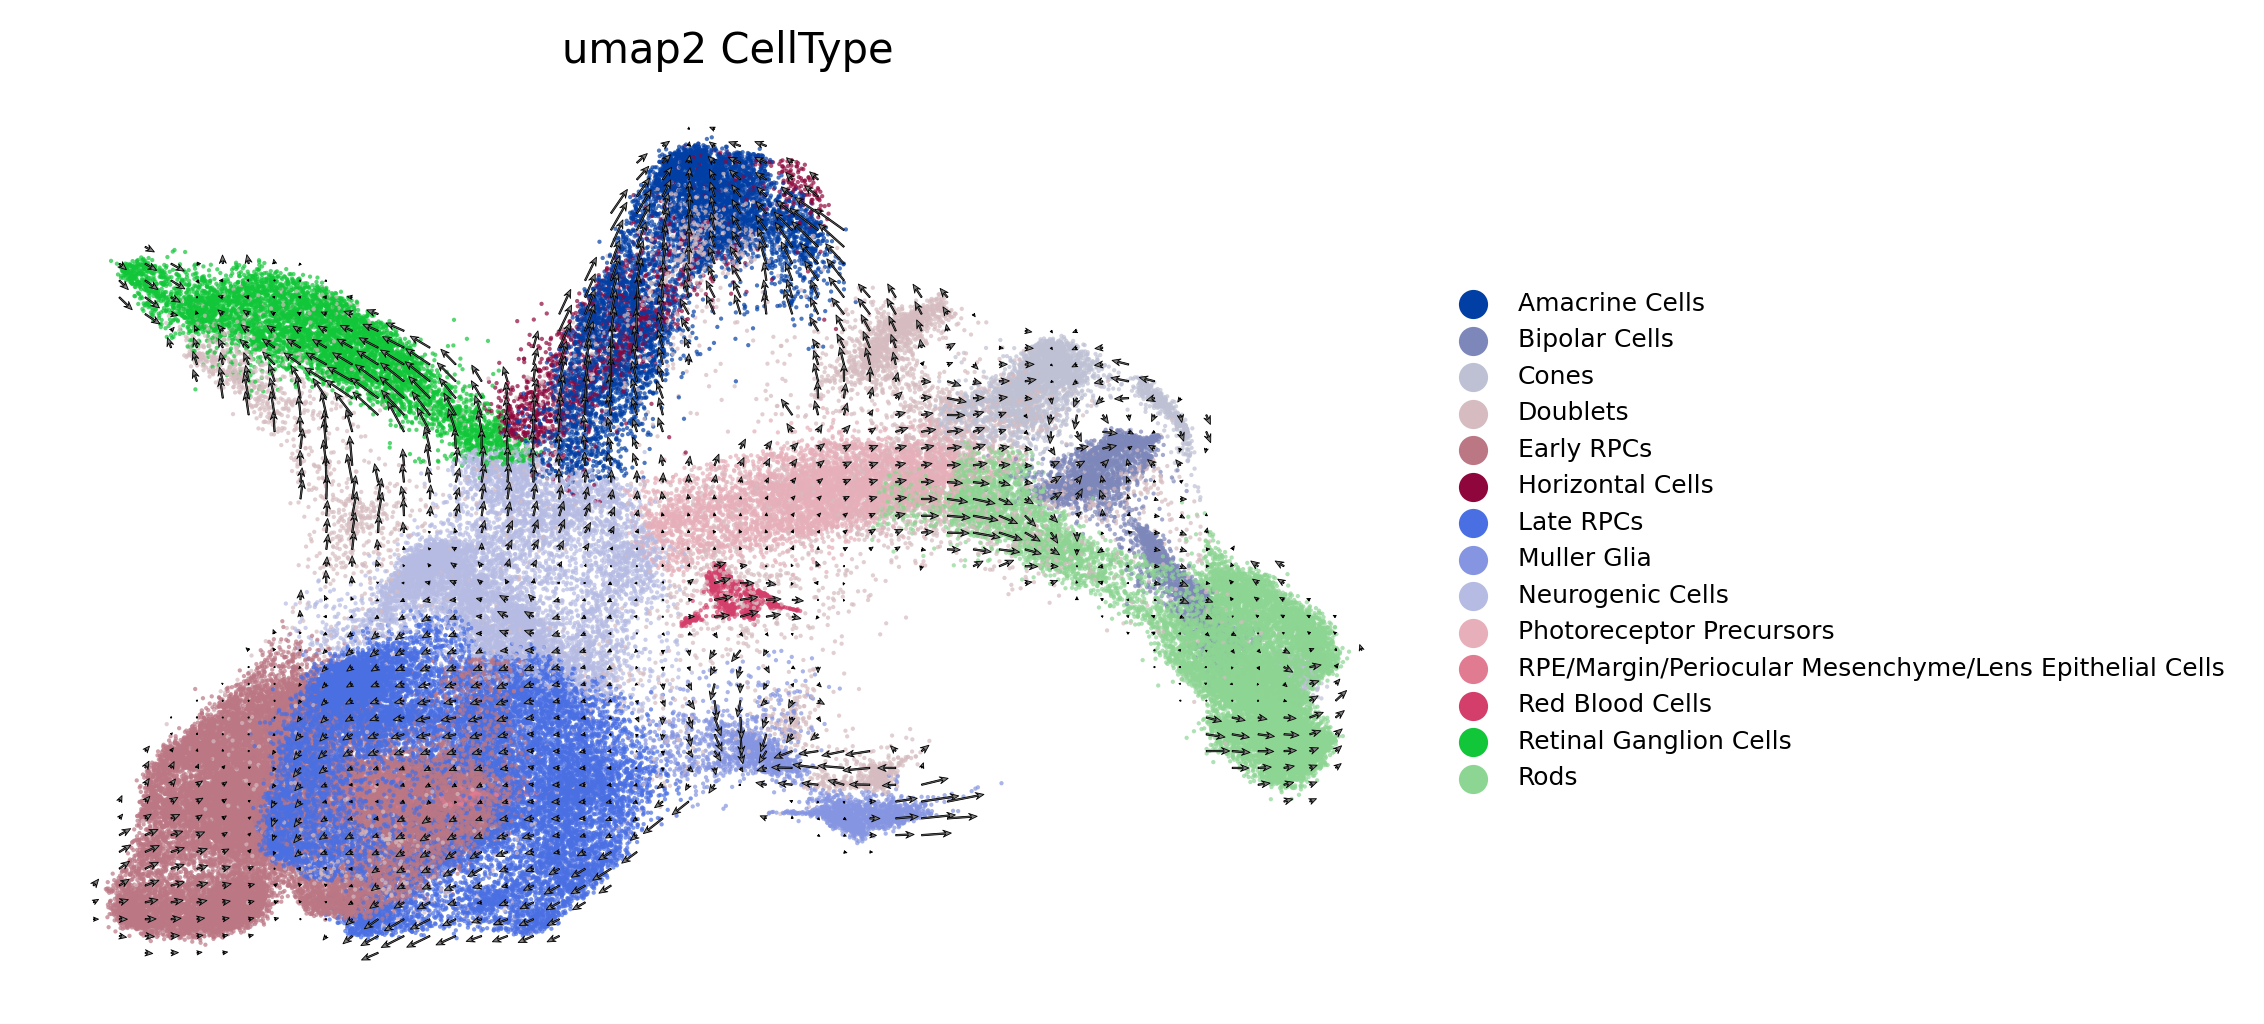

In [13]:
scv.pl.velocity_embedding_grid(adata, basis='umap', scale=0.4, dpi=300, color="umap2_CellType", legend_loc="right margin", legend_fontsize=6, alpha=0.7, save="umap_celltypes.pdf")

saving figure to file ./figures/scvelo_umap_time.pdf


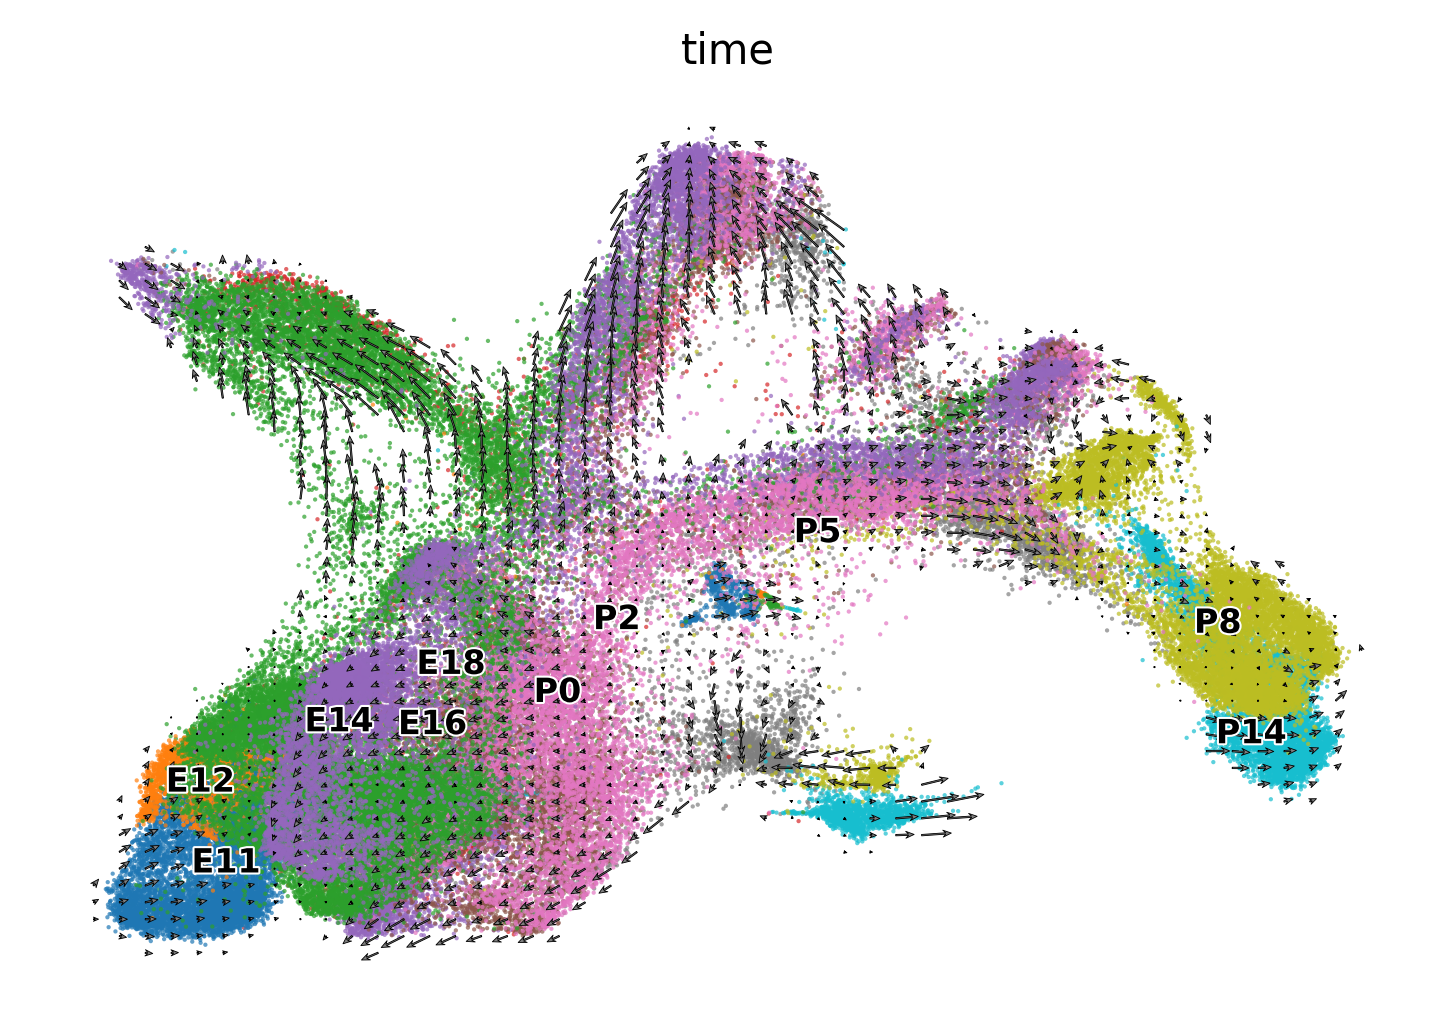

In [14]:
scv.pl.velocity_embedding_grid(adata, basis='umap', scale=0.4, dpi=300, color="time", legend_loc="on data", legend_fontsize=8, alpha=0.7, save="umap_time.pdf")

In [21]:
adata.var["gene"] = adata.var.index.map(them_genes["gene_short_name"])

In [22]:
adata.var = adata.var.reset_index()

In [23]:
adata.var.index = adata.var["gene"]

In [24]:
interest = ["Crx", "Nrl", "Otx2", "Pax6", "Rbpms" ,"Rlbp1"]

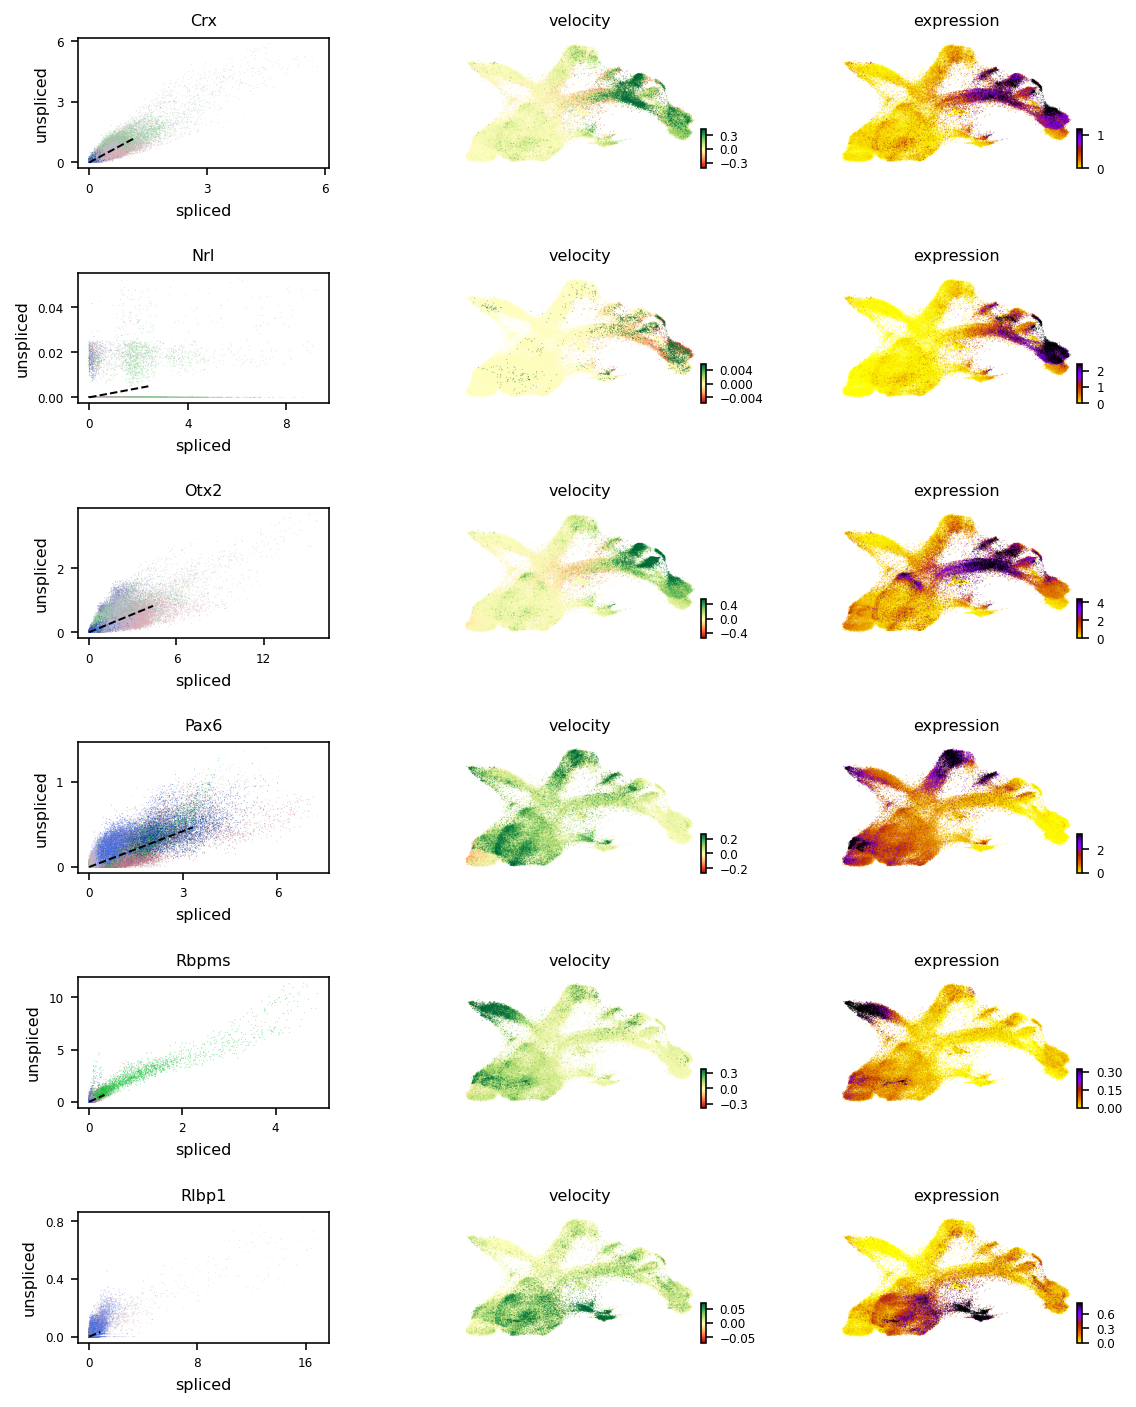

In [25]:
scv.pl.velocity(adata, basis='umap', var_names=interest, color="umap2_CellType", size=1)